# Probabilistic Graphical Models - DM1
## Antonin Berthon

In [2]:
import numpy as np
import pandas as pd
from math import *
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 4
plt.rcParams['figure.facecolor'] = 'white'

#Export figures
save_figure = False

# Data

In [3]:
t='A'
data = pd.read_csv("data/classification{}.train".format(t), sep = '\t', header = None)
data.columns = ['x1', 'x2', 'y']
print(data.shape)

(150, 3)


# LDA
We compute the MLE for the parameters $\pi$, $\mu_0$, $\mu_1$, $\Sigma$ using the following closed forms: 
$$ \pi = \frac{\sum\limits_{i=1}^n{\mathbb{1}_{(y_i = 1)}}}{n} $$

$$ \mu_j = \frac{\sum\limits_{i=1}^n{\mathbb{1}_{(y_i = j)}x_i}}
{\sum\limits_{i=1}^n{\mathbb{1}\{y_i = j\}}} $$

$$ \Sigma = \frac{1}{n}\sum\limits_{i=1}^n \sum\limits_{j=0,1} \mathbb{1}_{(y_i = j)}(x_i - \mu_j)(x_i-\mu_j)^T $$


In [4]:
n = np.shape(data)[0]
pi = np.mean(data['y'])

mu0 = list(np.mean(data[data['y'] == 0][['x1', 'x2']], axis=0))
mu1 = list(np.mean(data[data['y'] == 1][['x1', 'x2']], axis=0))
mu = np.array([mu0, mu1])

data['mu_0'] = np.where(data['y']==0, mu[0][0], mu[1][0])
data['mu_1'] = np.where(data['y']==1, mu[0][1], mu[1][1])

sigma = np.zeros((2, 2))
for i in range (n):
    if data['y'].iloc[i] == 0:
        x_mu = np.matrix(data[['x1', 'x2']].iloc[i] - mu[0])
    else:
        x_mu = np.matrix(data[['x1', 'x2']].iloc[i] - mu[1])
    sigma += np.dot(x_mu.T, x_mu)
sigma = sigma/n
sigma_1 = np.linalg.inv(sigma)

In [5]:
a = log(pi/(1-pi)) - 1/2 *(np.dot(np.dot(mu[1].T, sigma_1), mu[1]) - np.dot(np.dot(mu[0].T, sigma_1), mu[0]))
b = -np.dot((mu[0] - mu[1]).T, sigma_1)

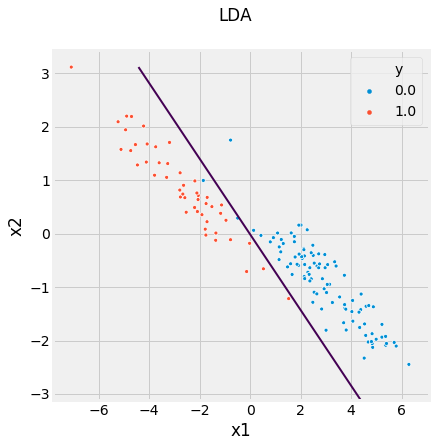

In [6]:
plt.figure(figsize = (6,6))
plt.suptitle("LDA")

# Plot the data
sns.scatterplot(data = data, x='x1', y='x2', hue='y')

# Plot the frontier
x_lim = np.max(abs(data['x1']))
y_lim = np.max(abs(data['x2']))
u = np.linspace(-x_lim, x_lim, 400)
v = np.linspace(-y_lim, y_lim, 400)
u, v = np.meshgrid(u, v)
plt.contour(u, v, u*b[0] + v*b[1] + a, [0])
if save_figure:
    plt.savefig('Figures/{}_LDA.png'.format(t), bbox_inches='tight', transparent = True)

# Logistic Regression

We now modelize this problem using a logistic regression model, in which we assume that $Y|X=x$ follows a Bernoulli distribution of parameter $(\sigma(w^Tx))$.

We want to find the weight vector $w$ that maximizes the log-likelihood:
$$l(w) = \sum\limits_{i=1}^n y_iw^Tx_i + log(\sigma(w^tx_i))$$
Note that we integrate a constant by working with $\widetilde{x}=\begin{pmatrix}x_i \\ 1\end{pmatrix}$.

Because the log-likelihood is differentiable and concave, we can find a global maximum by solving $\nabla_wl(w) = 0$
We compute the gradient:
$$\nabla_wl(w) = \sum\limits_{i=1}^n x_i(y_i-\eta_i)$$
with $\eta_i = \sigma(w^Tx_i)$

as well as the hessian :
$$Hl(w) = -\boldsymbol{X}^TDiag(\eta_i(1-\eta_i))\boldsymbol{X}$$

The IRLS algorithms minimizes l(w) by iterating the following formula :
$$w^{t+1} \leftarrow w^t + (\boldsymbol{X}^TDiag_{\eta^{(t)}}\boldsymbol{X})^{-1}\boldsymbol{X}^T(y-\eta^{(t)})$$

In [7]:
sigmoid = lambda x: 1/(1+exp(-x))

In [8]:
# Initialize the design matrix and diagonal function
X = np.hstack((data[['x1', 'x2']].values, np.ones((np.shape(data)[0], 1))))
Y = data['y']
get_eta_func = lambda w: (lambda x: sigmoid(np.dot(w.T, x)))
get_eta = lambda w: np.apply_along_axis(get_eta_func(w), 1, X)
get_D_eta =  lambda w: np.diag(get_eta(w))

# Initialize w0 randomly (since we are maximizing a concave function we do not care about the starting position)
w = np.random.rand(3)
new_w = w + np.linalg.inv(np.dot(np.dot(X.T, get_D_eta(w)), X)).dot(X.T).dot(Y-get_eta(w))
eps = 1e-3
while (abs(np.linalg.norm(new_w - w)) > eps):
    w = new_w
    new_w = w + np.linalg.inv(np.dot(np.dot(X.T, get_D_eta(w)), X)).dot(X.T).dot(Y-get_eta(w))
w = new_w

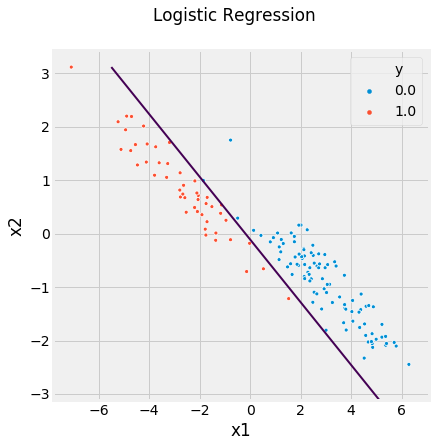

In [9]:
plt.figure(figsize = (6,6))
plt.suptitle("Logistic Regression")

# Plot the data
sns.scatterplot(data = data, x='x1', y='x2', hue='y')

# Plot the frontier
x_lim = np.max(abs(data['x1']))
y_lim = np.max(abs(data['x2']))
u = np.linspace(-x_lim, x_lim, 400)
v = np.linspace(-y_lim, y_lim, 400)
u, v = np.meshgrid(u, v)
plt.contour(u, v, w[0]*u + w[1]*v + w[2], [0])
if save_figure:
    plt.savefig('Figures/{}_logit.png'.format(t), bbox_inches='tight', transparent = True)

# Linear Regression

In a linear regression model, we make the assumption that $Y|X=x$ follows a normal distribution $\mathcal{N}(w^Tx, \sigma^2)$
Again, we take into account the offset by using $\widetilde{x}=\begin{pmatrix}x_i \\ 1\end{pmatrix}$.

Unlike the logistic regression model, the linear regression allows for a closed form solution with the normal equation:
$$ \boldsymbol{X^TX}w - \boldsymbol{X^T}y = 0$$
So that, if $\boldsymbol{X^TX}$ is invertible the maximum likelyhood estimator $\hat{w}$ can be computed with:
$$ \hat{w} = (\boldsymbol{X^TX})^{-1}\boldsymbol{X^T}y $$

In [10]:
X = np.hstack((data[['x1', 'x2']].values, np.ones((np.shape(data)[0], 1))))
Y = data['y']

w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)

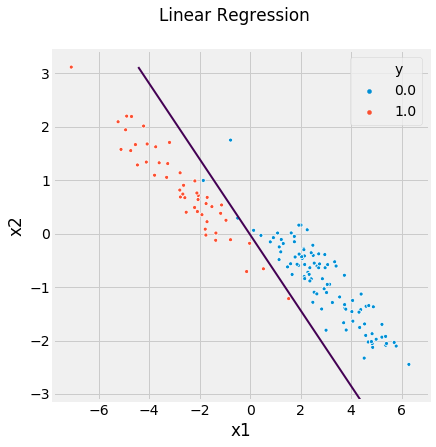

In [11]:
plt.figure(figsize = (6,6))
plt.suptitle("Linear Regression")

# Plot the data
sns.scatterplot(data = data, x='x1', y='x2', hue='y')

# Plot the frontier
x_lim = np.max(abs(data['x1']))
y_lim = np.max(abs(data['x2']))
u = np.linspace(-x_lim, x_lim, 400)
v = np.linspace(-y_lim, y_lim, 400)
u, v = np.meshgrid(u, v)
plt.contour(u, v, u*w[0] + v*w[1] + w[2], [0.5])
if save_figure:
    plt.savefig('Figures/{}_linear.png'.format(t), bbox_inches='tight', transparent = True)

# QDA

In [12]:
n = np.shape(data)[0]
pi = np.mean(data['y'])

mu0 = list(np.mean(data[data['y'] == 0][['x1', 'x2']], axis=0))
mu1 = list(np.mean(data[data['y'] == 1][['x1', 'x2']], axis=0))
mu = np.array([mu0, mu1])

data['mu_0'] = np.where(data['y']==0, mu[0][0], mu[1][0])
data['mu_1'] = np.where(data['y']==1, mu[0][1], mu[1][1])

sigmas = [np.zeros((2, 2)), np.zeros((2, 2))]
for i in range (n):
    if data['y'].iloc[i] == 0:
        x_mu = np.matrix(data[['x1', 'x2']].iloc[i] - mu[0])
        sigmas[0] += np.dot(x_mu.T, x_mu)
    else:
        x_mu = np.matrix(data[['x1', 'x2']].iloc[i] - mu[1])
        sigmas[1] += np.dot(x_mu.T, x_mu)
sigmas[0] = sigmas[0]/np.sum(data['y'] == 0)
sigmas[1] = sigmas[1]/np.sum(data['y'] == 1)
sigmas_1 = [np.linalg.inv(sigmas[0]), np.linalg.inv(sigmas[1])]

M = sigmas_1[1] - sigmas_1[0]
b = sigmas_1[1].T.dot(mu[1]) - sigmas_1[0].T.dot(mu[0])
a = log(pi*np.linalg.det(sigmas[0])**0.5/((1-pi)*np.linalg.det(sigmas[1])**0.5)) - 1/2 * (mu[1].T.dot(sigmas_1[1]).dot(mu[1]) - mu[0].T.dot(sigmas_1[0]).dot(mu[0]))

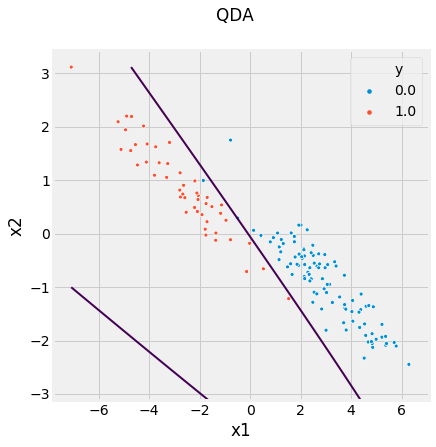

In [13]:
plt.figure(figsize = (6,6))
plt.suptitle("QDA")

# Plot the data
sns.scatterplot(data = data, x='x1', y='x2', hue='y')

# Plot the frontier
x_lim = np.max(abs(data['x1']))
y_lim = np.max(abs(data['x2']))
u = np.linspace(-x_lim, x_lim, 400)
v = np.linspace(-y_lim, y_lim, 400)
u, v = np.meshgrid(u, v)
plt.contour(u, v, 1/2*((v**2)*M[1][1] + 2*v*u*(M[0][1]) + (u**2)*M[0][0]) - v*b[1] - u*b[0] - a, [0])
plt.savefig('Figures/{}_QDA.png'.format(t), bbox_inches='tight', transparent = True)

# Model comparison 

In [14]:
class LDA_model:
    def __init__(self):
        self.a = None
        self.b = None
             
    def train(self, data):
        """Fits the labelled data given as input using LDA"""
        # Compute MLE variables
        n = np.shape(data)[0]
        pi = np.mean(data['y'])

        mu0 = list(np.mean(data[data['y'] == 0][['x1', 'x2']], axis=0))
        mu1 = list(np.mean(data[data['y'] == 1][['x1', 'x2']], axis=0))
        mu = np.array([mu0, mu1])

        data['mu_0'] = np.where(data['y']==0, mu[0][0], mu[1][0])
        data['mu_1'] = np.where(data['y']==1, mu[0][1], mu[1][1])

        sigma = np.zeros((2, 2))
        for i in range (n):
            if data['y'].iloc[i] == 0:
                x_mu = np.matrix(data[['x1', 'x2']].iloc[i] - mu[0])
            else:
                x_mu = np.matrix(data[['x1', 'x2']].iloc[i] - mu[1])
            sigma += np.dot(x_mu.T, x_mu)
        sigma = sigma/n
        sigma_1 = np.linalg.inv(sigma)
        
        # Computes variables a and b
        self.a = log(pi/(1-pi)) - 1/2 * (mu[1].T.dot(sigma_1).dot(mu[1]) - mu[0].T.dot(sigma_1).dot(mu[0]))
        self.b = -np.dot((mu[0] - mu[1]).T, sigma_1)
        
    def predict(self, data):
        """Return a vector of predictions for the unlabelled dataset provided as input"""
        predict_func = lambda x: sigmoid(self.a + self.b.T.dot(x)) > 0.5
        predictions = np.where(np.apply_along_axis(predict_func, 1, data), 1, 0)
        return predictions
        

In [15]:
class logistic_regression:
    def __init__(self, eps):
        """The property eps denotes the precision of the algorithm"""
        self.w = np.array([])
        self.eps = eps
            
    def train(self, data):
        """Fits the labelled data given as input using a logistic regression with the IRLS algorithm"""
        # Initialize the design matrix and diagonal function
        X = np.hstack((data[['x1', 'x2']].values, np.ones((np.shape(data)[0], 1))))
        Y = data['y']
        get_eta_func = lambda w: (lambda x: sigmoid(np.dot(w.T, x)))
        get_eta = lambda w: np.apply_along_axis(get_eta_func(w), 1, X)
        get_D_eta =  lambda w: np.diag(get_eta(w))

        # Initialize w0 randomly (since we are maximizing a concave function we do not care about the starting position)
        w = np.random.rand(3)
        new_w = w + np.linalg.inv(np.dot(np.dot(X.T, get_D_eta(w)), X)).dot(X.T).dot(Y-get_eta(w))
        eps = self.eps
        while (abs(np.linalg.norm(new_w - w)) > eps):
            w = new_w
            new_w = w + np.linalg.inv(np.dot(np.dot(X.T, get_D_eta(w)), X)).dot(X.T).dot(Y-get_eta(w))
        self.w = new_w
    
    def predict(self, data):
        """Return a vector of predictions for the unlabelled dataset provided as input"""
        X = np.hstack((data.values, np.ones((np.shape(data)[0], 1))))
        get_eta_func = lambda v: (lambda x: sigmoid(v.T.dot(x)))
        get_eta = lambda v: np.apply_along_axis(get_eta_func(v), 1, X)
        return np.where(get_eta(self.w) > 0.5, 1, 0)
    

In [16]:
class linear_regression:
    def __init__(self):
        self.w = np.array([])
            
    def train(self, data):
        """Updates the weight vector by solving a linear regression problem on the labelled data provided as input"""
        X = np.hstack((data[['x1', 'x2']].values, np.ones((np.shape(data)[0], 1))))
        Y = data['y']
        self.w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
        
    def predict(self, data):
        """Return a vector of predictions for the unlabelled dataset provided as input"""
        X = np.hstack((data.values, np.ones((np.shape(data)[0], 1))))
        return np.where(self.w.dot(X.T) > 0.5, 1, 0)

In [17]:
class QDA:
    def __init__(self):
        self.M = None
        self.a = None
        self.b = None
    
    def train(self, data):
        """Fits the labelled data given as input using LDA"""
        n = np.shape(data)[0]
        pi = np.mean(data['y'])

        mu0 = list(np.mean(data[data['y'] == 0.][['x1', 'x2']], axis=0))
        mu1 = list(np.mean(data[data['y'] == 1.][['x1', 'x2']], axis=0))
        mu = np.array([mu0, mu1])

        data['mu_0'] = np.where(data['y']==0., mu[0][0], mu[1][0])
        data['mu_1'] = np.where(data['y']==1., mu[0][1], mu[1][1])

        sigmas = [np.zeros((2, 2)), np.zeros((2, 2))]
        for i in range (n):
            if data['y'].iloc[i] == 0.:
                x_mu = np.matrix(data[['x1', 'x2']].iloc[i] - mu[0])
                sigmas[0] += np.dot(x_mu.T, x_mu)
            else:
                x_mu = np.matrix(data[['x1', 'x2']].iloc[i] - mu[1])
                sigmas[1] += np.dot(x_mu.T, x_mu)
        sigmas[0] = sigmas[0]/np.sum(data['y'] == 0)
        sigmas[1] = sigmas[1]/np.sum(data['y'] == 1)
        sigmas_1 = [np.linalg.inv(sigmas[0]), np.linalg.inv(sigmas[1])]

        self.M = sigmas_1[1] - sigmas_1[0]
        self.b = sigmas_1[1].T.dot(mu[1]) - sigmas_1[0].T.dot(mu[0])
        self.a = log(pi*np.linalg.det(sigmas[0])**0.5/((1-pi)*np.linalg.det(sigmas[1])**0.5)) - 1/2 * (mu[1].T.dot(sigmas_1[1]).dot(mu[1]) - mu[0].T.dot(sigmas_1[0]).dot(mu[0]))
        
    def predict(self, data):
        """Return a vector of predictions for the unlabelled dataset provided as input"""
        predict_func = lambda x: sigmoid(- 1/2 * x.T.dot(self.M).dot(x) + self.b.T.dot(x) + self.a) > 0.5
        predictions = np.where(np.apply_along_axis(predict_func, 1, data), 1, 0)
        return predictions


In [18]:
def get_model(model_name):
    if model_name == "LDA":
        return LDA_model()
    elif model_name == "logistic":
        return logistic_regression(eps=1e-3)
    elif model_name == "linear":
        return linear_regression()
    elif model_name == "QDA":
        return QDA()
    else:
        raise "Invalid model name"

In [19]:
def compute_error(labels, predictions):
    return 1-sum(labels == predictions)/labels.size

In [20]:
# This script iterates through all three data sets and displays the performance of each of the four methods
format_col = lambda data: data.rename(columns = {0:'x1', 1:'x2', 2:'y'})
get_data_train = lambda X: format_col(pd.read_csv("data/classification{}.train".format(X), sep = '\t', header = None))
get_data_test = lambda X: format_col(pd.read_csv("data/classification{}.test".format(X), sep = '\t', header = None))

datasets = ['A', 'B', 'C']

models = ["LDA", "logistic", "linear", "QDA"]

# Result dataframe
iterables = [["LDA", "logistic", "linear", "QDA"], ['train', 'test']]
index = pd.MultiIndex.from_product(iterables, names=['Model', 'Type'])
results = pd.DataFrame(columns=['Data A', 'Data B', 'Data C'], index= index)

for datatype in datasets:
    data_train = get_data_train(datatype)
    data_test = get_data_test(datatype)
    
    for m in models:
        model = get_model(m)
        model.train(data_train)
        predictions_train = model.predict(data_train[['x1', 'x2']])
        predictions_test = model.predict(data_test[['x1', 'x2']])
        
        train_error = compute_error(data_train['y'], predictions_train)
        test_error = compute_error(data_test['y'], predictions_test)
        
        dataname = "Data {}".format(datatype)
        results.xs((m, "train"))[dataname] = round(100*train_error, 2)
        results.xs((m, "test"))[dataname] = round(100*test_error, 2)

In [21]:
#Display results
results

Data A Data B Data C
Model    Type                      
LDA      train   1.33      3    5.5
         test       2   4.15   4.23
logistic train      0      2      4
         test    3.53   4.25    2.3
linear   train   1.33      3    5.5
         test    2.07   4.15   4.23
QDA      train   0.67   1.33   5.25
         test       2      2   3.83